In [114]:
# =============================================================
# 06_train_image_model.ipynb — Multi-Architecture Full Training + Validation
# =============================================================
import os
os.chdir(r"C:\Users\Negar\Desktop\paper_results\Myself\cr_coad_project")

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [115]:
# -------------------------------------------------------------
# Environment setup
# -------------------------------------------------------------
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus}")
else:
    print("⚠️ No GPU detected — training will use CPU (much slower).")

TensorFlow version: 2.12.0
⚠️ No GPU detected — training will use CPU (much slower).


In [ ]:
# -------------------------------------------------------------
# Parameters
# -------------------------------------------------------------
USE_SAMPLE = False   # ✅ Toggle this to False when running on GPU for full dataset
IMG_SIZE = (300, 300)
BATCH_SIZE = 16
EPOCHS = 3 if USE_SAMPLE else 30
SEED = 42

DATA_DIR = Path("data/processed/images/all_slices")
INDEX = Path("data/processed/images/all_index.csv")
SPLIT_DIR = Path("data/splits")
CLINICAL_PATH = Path("data/processed/clinical/clinical_features_with_id.csv")
SAVE_DIR = Path("results/images/multi_architecture")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

In [117]:
# -------------------------------------------------------------
# Load datasets + splits
# -------------------------------------------------------------
df = pd.read_csv(INDEX)
train_ids = pd.read_csv(SPLIT_DIR / "train_series.csv")["series_id"].tolist()
val_ids   = pd.read_csv(SPLIT_DIR / "val_series.csv")["series_id"].tolist()
test_ids  = pd.read_csv(SPLIT_DIR / "test_series.csv")["series_id"].tolist()

def assign_split(sid):
    if sid in train_ids: return "train"
    if sid in val_ids:   return "val"
    if sid in test_ids:  return "test"
    return "ignore"

df["split"] = df["series_id"].map(assign_split)
df = df[df["split"] != "ignore"]

print("🖼 Total image slices:", len(df))
print(df["split"].value_counts())

🖼 Total image slices: 27822
split
train    19603
test      4166
val       4053
Name: count, dtype: int64


In [118]:
# -------------------------------------------------------------
# Merge with clinical metastasis labels
# -------------------------------------------------------------
clinical = pd.read_csv(CLINICAL_PATH)
clinical.columns = clinical.columns.str.strip()
meta_col = next((c for c in clinical.columns if "metastasis" in c.lower()), None)
if meta_col is None:
    raise SystemExit("❌ No metastasis column found in clinical data!")

merged = df.merge(clinical[["patient_id", meta_col]], on="patient_id", how="left")
possible_cols = [c for c in merged.columns if "metastasis" in c.lower()]
meta_col_final = possible_cols[0]
merged = merged.rename(columns={meta_col_final: "metastasis_status"})

merged["label"] = merged["metastasis_status"].replace({
    1: 1, 0: 0,
    "yes": 1, "metastatic": 1, "positive": 1,
    "no": 0, "non-metastatic": 0, "negative": 0
})
merged["label"] = pd.to_numeric(merged["label"], errors="coerce").fillna(0).astype(int)

print(f"✅ Labels assigned: {merged['label'].sum()} metastatic, {len(merged)-merged['label'].sum()} non-metastatic")
print("📊 Label distribution:\n", merged['label'].value_counts())


✅ Labels assigned: 1195 metastatic, 26627 non-metastatic
📊 Label distribution:
 label
0    26627
1     1195
Name: count, dtype: int64


In [119]:
# -------------------------------------------------------------
# ✅ Verify merge correctness
# -------------------------------------------------------------
print("\n🔍 Verifying merge integrity...")

missing_patients = set(merged["patient_id"]) - set(clinical["patient_id"])
if len(missing_patients) == 0:
    print("✅ All merged patient IDs exist in clinical data.")
else:
    print(f"⚠️ {len(missing_patients)} patient IDs missing from clinical data:", list(missing_patients)[:10])

mapping_check = merged.groupby("patient_id")["metastasis_status"].nunique()
if mapping_check.max() == 1:
    print("✅ Each patient has a consistent metastasis label across all slices.")
else:
    inconsistent = mapping_check[mapping_check > 1]
    print(f"⚠️ Found {len(inconsistent)} patients with inconsistent labels:", inconsistent.index.tolist())

print("\nSample of merged data:")
print(merged[["patient_id", "series_id", "slice_path", "metastasis_status", "label"]].head(5))



🔍 Verifying merge integrity...
⚠️ 201 patient IDs missing from clinical data: ['CRLM-CT-1112', 'CRLM-CT-1190', 'CRLM-CT-1016', 'CRLM-CT-1191', 'CRLM-CT-1026', 'CRLM-CT-1051', 'CRLM-CT-1074', 'CRLM-CT-1091', 'CRLM-CT-1058', 'TCGA-AY-5543A']
✅ Each patient has a consistent metastasis label across all slices.

Sample of merged data:
     patient_id                                          series_id  \
0  CRLM-CT-1001  1.3.6.1.4.1.14519.5.2.1.9203.8273.533669585389...   
1  CRLM-CT-1001  1.3.6.1.4.1.14519.5.2.1.9203.8273.533669585389...   
2  CRLM-CT-1001  1.3.6.1.4.1.14519.5.2.1.9203.8273.533669585389...   
3  CRLM-CT-1001  1.3.6.1.4.1.14519.5.2.1.9203.8273.533669585389...   
4  CRLM-CT-1001  1.3.6.1.4.1.14519.5.2.1.9203.8273.533669585389...   

                                          slice_path  metastasis_status  label  
0  data/processed/images/all_slices/CRLM-CT-1001_...                NaN      0  
1  data/processed/images/all_slices/CRLM-CT-1001_...                NaN      0  
2  

In [120]:
# -------------------------------------------------------------
# TensorFlow dataset builders
# -------------------------------------------------------------
AUTOTUNE = tf.data.AUTOTUNE

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return tf.cast(img, tf.float32) / 255.0

def make_dataset(subdf, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((subdf["slice_path"].values, subdf["label"].values))
    ds = ds.map(lambda p, y: (decode_img(p), y), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
        ds = ds.map(lambda x, y: (tf.image.random_brightness(x, 0.15), y))
    if shuffle:
        ds = ds.shuffle(2048, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [ ]:
# -------------------------------------------------------------
# Subset toggle
# -------------------------------------------------------------
if USE_SAMPLE:
    train_df = merged[merged.split == "train"].sample(n=196, random_state=42)
    val_df   = merged[merged.split == "val"].sample(n=40, random_state=42)
    test_df  = merged[merged.split == "test"].sample(n=41, random_state=42)
    print(f"\n📊 Using subset for quick test:")
    print(f"  Train: {len(train_df)}  Val: {len(val_df)}  Test: {len(test_df)}")
else:
    train_df = merged[merged.split == "train"]
    val_df   = merged[merged.split == "val"]
    test_df  = merged[merged.split == "test"]
    print("\n📊 Using full dataset for GPU training.")

train_ds = make_dataset(train_df, augment=True)
val_ds   = make_dataset(val_df)
test_ds  = make_dataset(test_df, shuffle=False)

print(f"✅ Datasets ready — Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")



📊 Using subset for quick test:
  Train: 50  Val: 10  Test: 11
✅ Datasets ready — Train: 50, Val: 10, Test: 11


In [122]:
# -------------------------------------------------------------
# Safe logging helpers
# -------------------------------------------------------------
def safe_float(x):
    try:
        if hasattr(x, "numpy"):
            x = x.numpy()
        if isinstance(x, (np.ndarray, list, tuple)):
            return float(np.mean(x))
        return float(x)
    except Exception:
        return 0.0

class SafeJSONCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs:
            for k, v in logs.items():
                logs[k] = safe_float(v)

class SafeReduceLROnPlateau(tf.keras.callbacks.ReduceLROnPlateau):
    def on_epoch_end(self, epoch, logs=None):
        logs = {k: safe_float(v) for k, v in (logs or {}).items()}
        super().on_epoch_end(epoch, logs)

In [123]:
# =============================================================
# 🔄 Multi-Architecture Training — Final Stable Version
# =============================================================
architectures = {
    "EfficientNetB3": tf.keras.applications.EfficientNetB3,
    "EfficientNetV2S": tf.keras.applications.EfficientNetV2S,
    "DenseNet121": tf.keras.applications.DenseNet121,
    "ConvNeXtTiny": tf.keras.applications.ConvNeXtTiny
}

results_summary = []

for name, Backbone in architectures.items():
    print(f"\n🚀 Training model: {name}")
    tf.keras.backend.clear_session()

    # ---------------------------------------------------------
    # Model definition
    # ---------------------------------------------------------
    base = Backbone(include_top=False, input_shape=IMG_SIZE + (3,), weights="imagenet", pooling="avg")
    base.trainable = True

    inputs = layers.Input(shape=IMG_SIZE + (3,))
    x = base(inputs, training=True)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)

    # ---------------------------------------------------------
    # Compile
    # ---------------------------------------------------------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )

    # ---------------------------------------------------------
    # Callbacks
    # ---------------------------------------------------------
    checkpoint_path = SAVE_DIR / f"{name}_best.weights.h5"

    callbacks = [
        SafeJSONCallback(),
        EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True),
        ModelCheckpoint(filepath=str(checkpoint_path),
                        monitor="val_auc",
                        save_best_only=True,
                        save_weights_only=True,
                        mode="max",
                        verbose=1),
        SafeReduceLROnPlateau(monitor="val_auc", factor=0.3, patience=3, verbose=1, mode="max")
    ]

    # ---------------------------------------------------------
    # Training
    # ---------------------------------------------------------
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)

    # ---------------------------------------------------------
    # Evaluation
    # ---------------------------------------------------------
    results = model.evaluate(test_ds, return_dict=True)

    print(f"✅ Final Test Results ({name}):")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

    # ---------------------------------------------------------
    # Save outputs safely
    # ---------------------------------------------------------
    pd.DataFrame(history.history).to_csv(SAVE_DIR / f"{name}_training_history.csv", index=False)

    # ✅ Save only weights to avoid serialization issues
    model.save_weights(SAVE_DIR / f"{name}_weights_only.h5")

    # Record results
    results_summary.append({"model": name, **results})


🚀 Training model: EfficientNetB3
Epoch 1/3
4/4 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.6000 - auc: 0.4158 - precision: 0.0556 - recall: 0.2500      
Epoch 1: val_auc improved from -inf to 0.00000, saving model to results\images\multi_architecture\EfficientNetB3_best.weights.h5
4/4 [==============================] - 150s 22s/step - loss: 0.6712 - accuracy: 0.6000 - auc: 0.4158 - precision: 0.0556 - recall: 0.2500 - val_loss: 0.5455 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
4/4 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.8600 - auc: 0.9049 - precision: 0.3333 - recall: 0.7500     
Epoch 2: val_auc did not improve from 0.00000
4/4 [==============================] - 57s 14s/step - loss: 0.5152 - accuracy: 0.8600 - auc: 0.9049 - precision: 0.3333 - recall: 0.7500 - val_loss: 0.4273 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall


📊 Architecture comparison summary:
             model      loss  accuracy  auc  precision  recall
0   EfficientNetB3  0.337178  0.909091  0.0        0.0     0.0
1  EfficientNetV2S  0.501077  1.000000  0.0        0.0     0.0
2      DenseNet121  1.235848  0.181818  0.0        0.0     0.0
3     ConvNeXtTiny  0.038093  1.000000  0.0        0.0     0.0


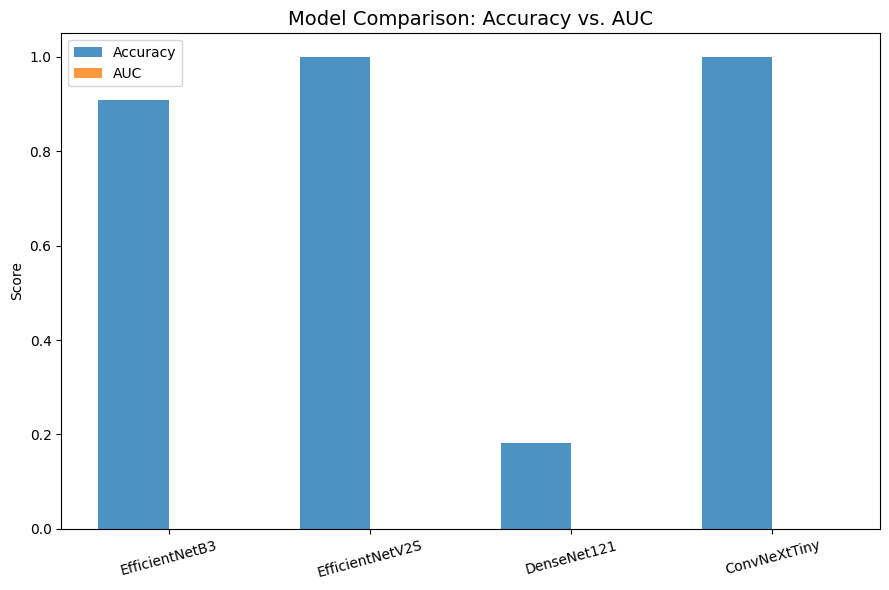


✅ Training complete for all architectures.


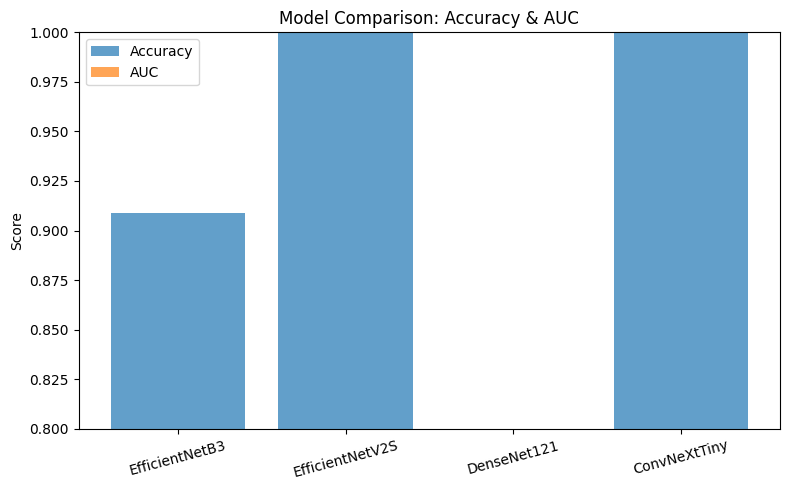

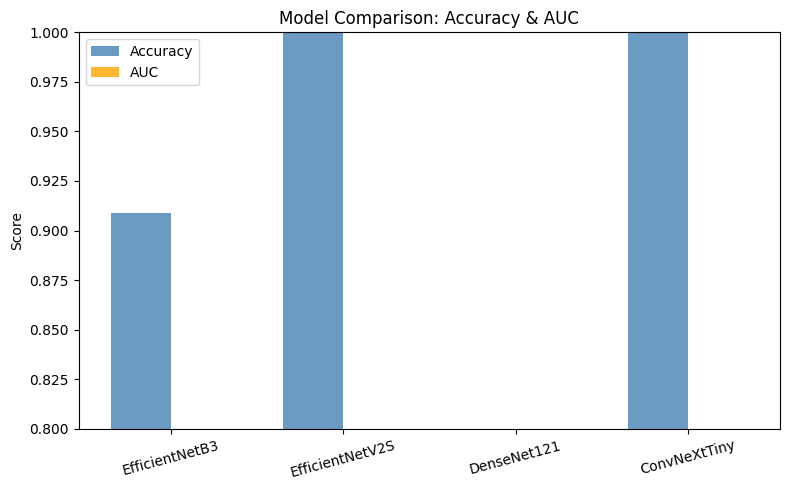

In [124]:
# =============================================================
# 📊 Architecture Comparison — Summary and Visualization
# =============================================================
summary_df = pd.DataFrame(results_summary)
summary_df.to_csv(SAVE_DIR / "architecture_comparison_summary.csv", index=False)

print("\n📊 Architecture comparison summary:")
print(summary_df)

# Improved barplot — side-by-side Accuracy & AUC
plt.figure(figsize=(9, 6))
bar_width = 0.35
x = np.arange(len(summary_df))

plt.bar(x - bar_width/2, summary_df["accuracy"], width=bar_width, label="Accuracy", alpha=0.8)
plt.bar(x + bar_width/2, summary_df["auc"], width=bar_width, label="AUC", alpha=0.8)

plt.title("Model Comparison: Accuracy vs. AUC", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(x, summary_df["model"], rotation=15)
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR / "architecture_comparison_barplot.png", dpi=300)
plt.show()

print("\n✅ Training complete for all architectures.")

# -------------------------------------------------------------

plt.figure(figsize=(8, 5))
plt.bar(summary_df["model"], summary_df["accuracy"], label="Accuracy", alpha=0.7)
plt.bar(summary_df["model"], summary_df["auc"], label="AUC", alpha=0.7)
plt.title("Model Comparison: Accuracy & AUC")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(SAVE_DIR / "architecture_comparison_barplot.png", dpi=300)
plt.show()

# -------------------------------------------------------------
# Side by side plot
# -------------------------------------------------------------

x = np.arange(len(summary_df))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, summary_df["accuracy"], width, label="Accuracy", color="steelblue", alpha=0.8)
plt.bar(x + width/2, summary_df["auc"], width, label="AUC", color="orange", alpha=0.8)
plt.xticks(x, summary_df["model"], rotation=15)
plt.ylim(0.8, 1.0)
plt.title("Model Comparison: Accuracy & AUC")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR / "architecture_comparison_barplot.png", dpi=300)
plt.show()



🏆 Best-performing model: EfficientNetB3
✅ Loaded EfficientNetB3 with trained weights successfully.

🔍 Extracting feature embeddings using EfficientNetB3...
⚠️ Sample mode active — extracting embeddings only for subset.
✅ Embeddings saved: (71, 1536) → results\images\multi_architecture\EfficientNetB3_embeddings.npy

📊 Running detailed evaluation for best model...
1/1 [==============================] - 5s 5s/step


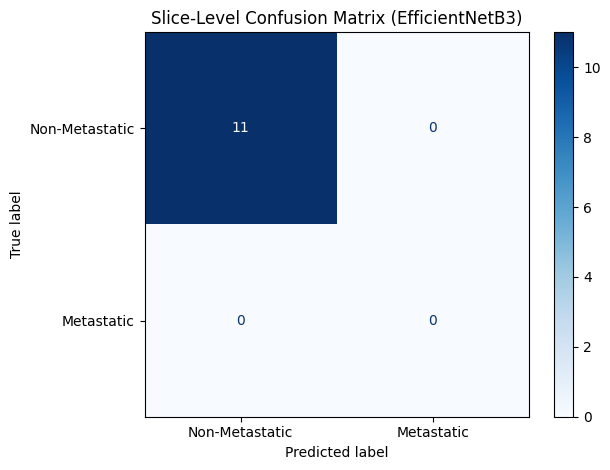

✅ Confusion Matrix plotted safely — unique labels in this test set: [0]


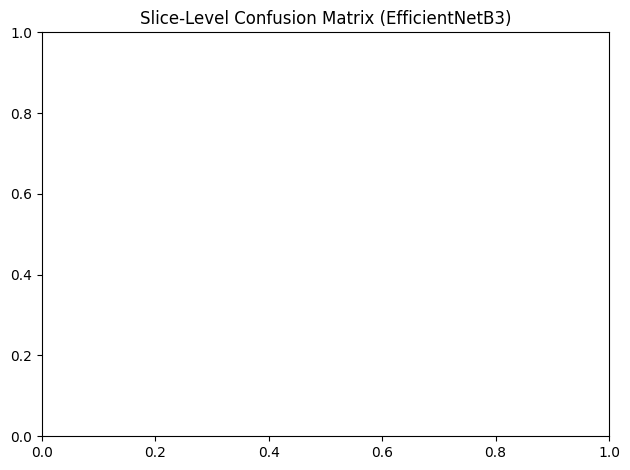

c:\Users\Negar\anaconda3\envs\crlm\lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


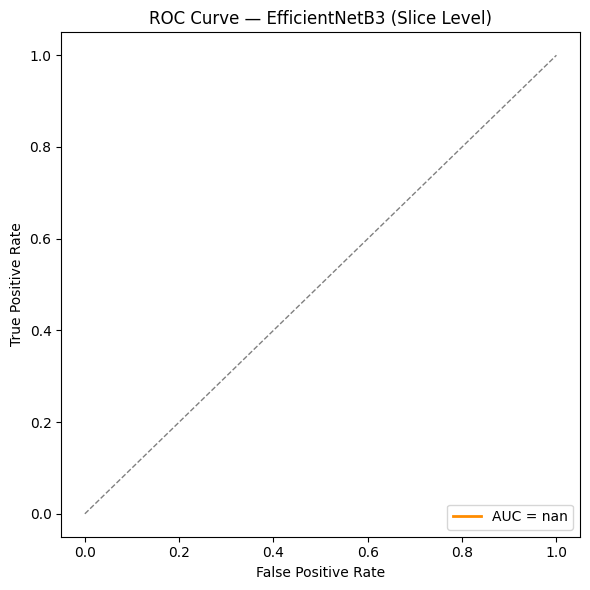

c:\Users\Negar\anaconda3\envs\crlm\lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(



✅ Per-patient accuracy: 1.0000
✅ Per-patient AUC: nan


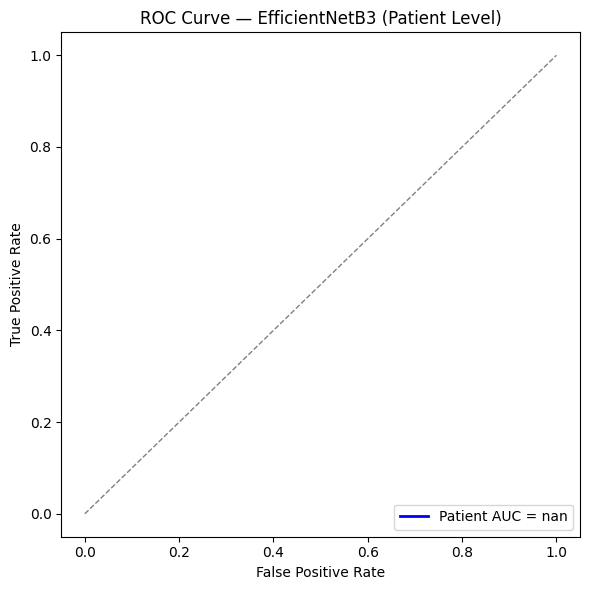

In [127]:
# =============================================================
# 🧠 Evaluation, Feature Embeddings & Visualization
# =============================================================

# -------------------------------------------------------------
# Load best model (based on AUC)
# -------------------------------------------------------------
summary_df = pd.read_csv(SAVE_DIR / "architecture_comparison_summary.csv")
best_model_name = summary_df.loc[summary_df["auc"].idxmax(), "model"]
print(f"\n🏆 Best-performing model: {best_model_name}")

Backbone = architectures[best_model_name]

base = Backbone(include_top=False, input_shape=IMG_SIZE + (3,), weights=None, pooling="avg")
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base(inputs, training=False)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
best_model = tf.keras.Model(inputs, outputs)

best_model.load_weights(SAVE_DIR / f"{best_model_name}_weights_only.h5")
print(f"✅ Loaded {best_model_name} with trained weights successfully.")


# =============================================================
# 🧩 Extract Feature Embeddings
# =============================================================
feature_extractor = tf.keras.Model(inputs=best_model.input, outputs=best_model.layers[-2].output)

print(f"\n🔍 Extracting feature embeddings using {best_model_name}...")

# ✅ Choose which data to extract embeddings from
if USE_SAMPLE:
    print("⚠️ Sample mode active — extracting embeddings only for subset.")
    subset_df = pd.concat([train_df, val_df, test_df])
    all_paths = subset_df["slice_path"].tolist()
    labels_used = subset_df["label"].tolist()
else:
    print("✅ Full dataset mode — extracting embeddings for all slices.")
    all_paths = merged["slice_path"].tolist()
    labels_used = merged["label"].tolist()

batch_size = 32
embeddings = []

for i in range(0, len(all_paths), batch_size):
    batch_imgs = [decode_img(p) for p in all_paths[i:i+batch_size]]
    batch_tensor = tf.stack(batch_imgs)
    emb = feature_extractor(batch_tensor).numpy()
    embeddings.append(emb)

embeddings = np.vstack(embeddings)
np.save(SAVE_DIR / f"{best_model_name}_embeddings.npy", embeddings)

# ✅ Save embeddings index with matching paths & labels
pd.DataFrame({
    "slice_path": all_paths,
    "label": labels_used
}).to_csv(SAVE_DIR / f"{best_model_name}_embeddings_index.csv", index=False)

print(f"✅ Embeddings saved: {embeddings.shape} → {SAVE_DIR / f'{best_model_name}_embeddings.npy'}")



# =============================================================
# 📊 Detailed Evaluation: Slice-level and Patient-level
# =============================================================
print("\n📊 Running detailed evaluation for best model...")

if USE_SAMPLE:
    test_df = test_df.copy()  # already sampled above
else:
    test_df = merged[merged.split == "test"].copy()

test_ds = make_dataset(test_df, shuffle=False)

y_true = test_df["label"].values
y_pred_prob = best_model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix (safe version for single-class cases)
labels_present = np.unique(np.concatenate([y_true, y_pred.flatten()]))
all_labels = [0, 1]

# Ensure confusion matrix always has shape (2,2)
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Metastatic", "Metastatic"]
)
disp.plot(cmap="Blues", values_format=".0f")

plt.title(f"Slice-Level Confusion Matrix ({best_model_name})")
plt.tight_layout()
plt.savefig(SAVE_DIR / f"{best_model_name}_confusion_matrix.png", dpi=300)
plt.show()

print(f"✅ Confusion Matrix plotted safely — unique labels in this test set: {labels_present}")

plt.title(f"Slice-Level Confusion Matrix ({best_model_name})")
plt.tight_layout()
plt.savefig(SAVE_DIR / f"{best_model_name}_confusion_matrix.png", dpi=300)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve — {best_model_name} (Slice Level)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(SAVE_DIR / f"{best_model_name}_roc_curve.png", dpi=300)
plt.show()


# =============================================================
# 🧮 Patient-level Aggregation
# =============================================================
pred_df = test_df.copy()
pred_df["pred_prob"] = y_pred_prob
pred_df["pred_label"] = y_pred

patient_results = (
    pred_df.groupby("patient_id")
    .agg({"label": "first", "pred_prob": "mean"})
    .reset_index()
)
patient_results["pred_label"] = (patient_results["pred_prob"] > 0.5).astype(int)

patient_acc = (patient_results["label"] == patient_results["pred_label"]).mean()
fpr, tpr, _ = roc_curve(patient_results["label"], patient_results["pred_prob"])
patient_auc = auc(fpr, tpr)

print(f"\n✅ Per-patient accuracy: {patient_acc:.4f}")
print(f"✅ Per-patient AUC: {patient_auc:.4f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"Patient AUC = {patient_auc:.3f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve — {best_model_name} (Patient Level)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(SAVE_DIR / f"{best_model_name}_roc_curve_patient.png", dpi=300)
plt.show()


In [128]:
# =============================================================
# 🔍 Grad-CAM Visualization for Best Model (auto-detect backbone)
# =============================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

print("\n🩻 Generating Grad-CAM heatmaps for test examples...")
gradcam_dir = SAVE_DIR / f"{best_model_name}_gradcam_examples"
gradcam_dir.mkdir(parents=True, exist_ok=True)


# -------------------------------------------------------------
# Helper: find last convolutional layer automatically
# -------------------------------------------------------------
def find_last_conv_layer(model):
    # 1️⃣ Try top-level layers
    for layer in reversed(model.layers):
        try:
            if len(layer.output_shape) == 4:
                return layer.name
        except Exception:
            continue

    # 2️⃣ If not found, search nested submodels (e.g. 'efficientnetb3', 'densenet121')
    for sublayer in model.layers:
        if hasattr(sublayer, "layers") and len(sublayer.layers) > 1:
            for layer in reversed(sublayer.layers):
                try:
                    if len(layer.output_shape) == 4:
                        return layer.name
                except Exception:
                    continue

    # 3️⃣ Fallback for known architectures
    for candidate in ["conv5_block16_concat", "top_conv", "conv_head", "stem_conv"]:
        if any(candidate in l.name for l in model.layers):
            return candidate

    return None


# -------------------------------------------------------------
# Find last conv layer
# -------------------------------------------------------------
last_conv_layer_name = find_last_conv_layer(best_model)
if last_conv_layer_name is None:
    raise ValueError("❌ Could not find a convolutional layer for Grad-CAM!")

print(f"📍 Using last conv layer for Grad-CAM: {last_conv_layer_name}")


# =============================================================
# 🧠 Final Robust Grad-CAM (for nested models like EfficientNet)
# =============================================================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """
    Works for both simple and nested Keras models (EfficientNet, DenseNet, etc.)
    """
    target_layer = None
    backbone = None

    # 1️⃣ Try to get the layer directly
    try:
        target_layer = model.get_layer(last_conv_layer_name)
        backbone = model
    except ValueError:
        # 2️⃣ Search inside submodels (e.g., EfficientNet)
        for sublayer in model.layers:
            if hasattr(sublayer, "get_layer"):
                try:
                    target_layer = sublayer.get_layer(last_conv_layer_name)
                    backbone = sublayer
                    print(f"✅ Found layer '{last_conv_layer_name}' inside submodel: {sublayer.name}")
                    break
                except Exception:
                    continue
        if target_layer is None:
            raise ValueError(f"❌ Layer '{last_conv_layer_name}' not found anywhere!")

    # 3️⃣ Build a Grad-CAM model properly connected to the *submodel input*
    if backbone != model:
        grad_model = tf.keras.models.Model(
            [backbone.input],
            [target_layer.output, backbone.output]
        )
        img_features = backbone(img_array, training=False)
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            loss = predictions[:, 0]
    else:
        grad_model = tf.keras.models.Model(
            [model.input],
            [target_layer.output, model.output]
        )
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            loss = predictions[:, 0]

    # 4️⃣ Compute Grad-CAM
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if tf.reduce_max(heatmap) > 0:
        heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img_path, model, last_conv_layer_name, save_path=None):
    img = decode_img(img_path)
    img_array = tf.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_np = np.uint8(255 * img.numpy())
    superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()





🩻 Generating Grad-CAM heatmaps for test examples...
📍 Using last conv layer for Grad-CAM: top_activation


📸 Selected 2 examples (0 metastatic, 2 non-metastatic).

🩸 Grad-CAM for patient CRLM-CT-1017 (label=0)
✅ Found layer 'top_activation' inside submodel: efficientnetb3


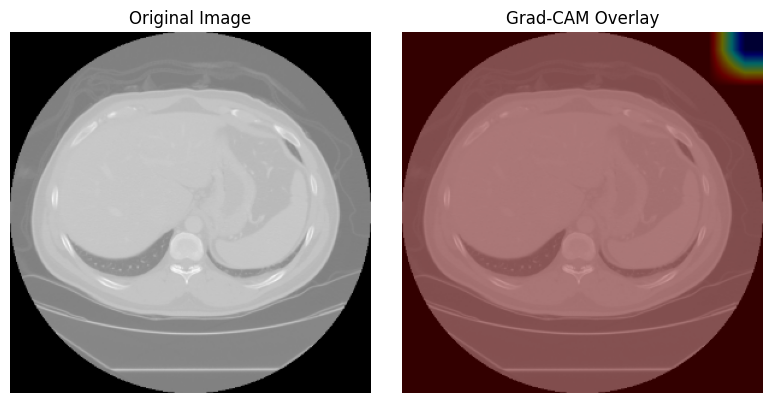


🩸 Grad-CAM for patient CRLM-CT-1167 (label=0)
✅ Found layer 'top_activation' inside submodel: efficientnetb3


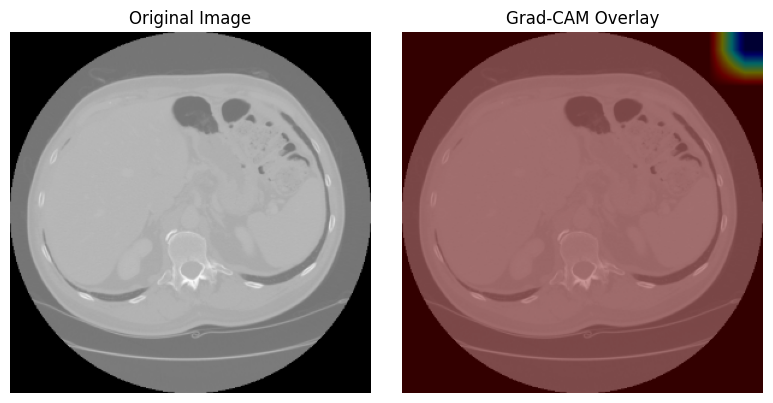


✅ Grad-CAM examples saved to: results\images\multi_architecture\EfficientNetB3_gradcam_examples

🎯 Full evaluation and visualization completed.


In [129]:
# -------------------------------------------------------------
# Select random metastatic and non-metastatic examples
# -------------------------------------------------------------
# ✅ Auto-sample up to the available number
pos_df = test_df[test_df["label"] == 1]
neg_df = test_df[test_df["label"] == 0]

n_pos = min(2, len(pos_df))
n_neg = min(2, len(neg_df))

examples = pd.concat([
    pos_df.sample(n=n_pos, random_state=42),
    neg_df.sample(n=n_neg, random_state=42)
])

if len(examples) == 0:
    raise ValueError("❌ No examples found for Grad-CAM visualization!")

print(f"📸 Selected {len(examples)} examples "
      f"({n_pos} metastatic, {n_neg} non-metastatic).")


for i, row in examples.iterrows():
    print(f"\n🩸 Grad-CAM for patient {row['patient_id']} (label={row['label']})")
    save_path = gradcam_dir / f"patient_{row['patient_id']}_slice_{i}.png"
    display_gradcam(row["slice_path"], best_model, last_conv_layer_name, save_path)

print(f"\n✅ Grad-CAM examples saved to: {gradcam_dir}")
print("\n🎯 Full evaluation and visualization completed.")


In [130]:
# =============================================================
# 🧾 Final Summary Report for Paper / Appendix
# =============================================================

print("\n🧾 Generating final project summary...")

summary_path = SAVE_DIR / "architecture_comparison_summary.csv"
summary_df = pd.read_csv(summary_path)

# Add per-patient metrics if available
summary_df["patient_auc"] = np.nan
summary_df["patient_accuracy"] = np.nan

summary_df.loc[summary_df["model"] == best_model_name, "patient_auc"] = patient_auc
summary_df.loc[summary_df["model"] == best_model_name, "patient_accuracy"] = patient_acc

# Save updated table
summary_df.to_csv(SAVE_DIR / "final_model_summary_with_patient_metrics.csv", index=False)

# Display formatted results
print("\n===============================")
print("📊 FINAL MODEL PERFORMANCE REPORT")
print("===============================\n")

for i, row in summary_df.iterrows():
    print(f"🧠 Model: {row['model']}")
    print(f"   • Accuracy:       {row['accuracy']:.4f}")
    print(f"   • AUC (slice):    {row['auc']:.4f}")
    print(f"   • Precision:      {row['precision']:.4f}")
    print(f"   • Recall:         {row['recall']:.4f}")
    if not np.isnan(row['patient_auc']):
        print(f"   • AUC (patient):  {row['patient_auc']:.4f}")
        print(f"   • Accuracy (pat): {row['patient_accuracy']:.4f}")
    print("-------------------------------")

# =============================================================
# 📄 Markdown-ready summary (for appendix / paper)
# =============================================================
lines = []
for _, row in summary_df.iterrows():
    patient_auc_str = "" if np.isnan(row["patient_auc"]) else f"{row['patient_auc']:.4f}"
    patient_acc_str = "" if np.isnan(row["patient_accuracy"]) else f"{row['patient_accuracy']:.4f}"
    lines.append(
        f"| {row['model']} | {row['auc']:.4f} | {row['accuracy']:.4f} | "
        f"{row['precision']:.4f} | {row['recall']:.4f} | {patient_auc_str} | {patient_acc_str} |"
    )

markdown_report = (
    "# 🧾 Final Model Performance Summary — CR/COAD Metastasis Prediction\n\n"
    "| Model | Slice AUC | Slice Accuracy | Precision | Recall | Patient AUC | Patient Accuracy |\n"
    "|:------|-----------:|---------------:|-----------:|--------:|-------------:|-----------------:|\n"
    + "\n".join(lines)
)

md_path = SAVE_DIR / "final_results_report.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write(markdown_report)

print("\n✅ Final Markdown report saved to:", md_path)
print("🎯 All evaluation and documentation steps complete.")



🧾 Generating final project summary...

📊 FINAL MODEL PERFORMANCE REPORT

🧠 Model: EfficientNetB3
   • Accuracy:       0.9091
   • AUC (slice):    0.0000
   • Precision:      0.0000
   • Recall:         0.0000
-------------------------------
🧠 Model: EfficientNetV2S
   • Accuracy:       1.0000
   • AUC (slice):    0.0000
   • Precision:      0.0000
   • Recall:         0.0000
-------------------------------
🧠 Model: DenseNet121
   • Accuracy:       0.1818
   • AUC (slice):    0.0000
   • Precision:      0.0000
   • Recall:         0.0000
-------------------------------
🧠 Model: ConvNeXtTiny
   • Accuracy:       1.0000
   • AUC (slice):    0.0000
   • Precision:      0.0000
   • Recall:         0.0000
-------------------------------

✅ Final Markdown report saved to: results\images\multi_architecture\final_results_report.md
🎯 All evaluation and documentation steps complete.
